# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3:
## Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

Populating the interactive namespace from numpy and matplotlib


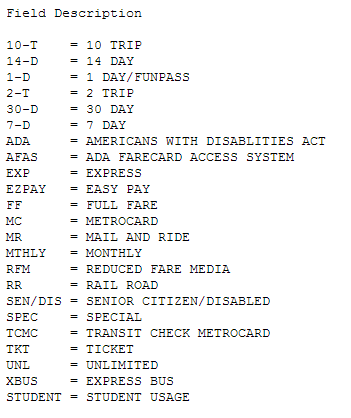

In [1]:
import pylab as pl
import numpy as np
import pandas as pd

%pylab inline

from IPython.display import Image
Image(filename = "Ridetypes.png")

Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

##note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## When I ask you "what station did somethig", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "what ridership type" you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average)


# Possibly useful functions

## I used a variety of functions, most of them you are familiar with already. here are a few that you may not have encounvered yet which I used. 
## (But you do not have to use them! there are many ways to do things and you do not have to solve this problem like I did)

* the numpy function np.where() returns the index where a condition is true. it is slow and inefficient but very intuitive and convenient

* the nupy functions np.nansum(), np.sum(), np.nanmean() etc get as parameter an array and the axis along which to sum. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...

* to find periodicity you can use fourier transforms. if you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft  
     
     np.fft.rfft(mydata) 
     
     will return the fourier transform, but what you want is its absolute value: np.abs(). Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

     np.fft.rfftfreq(N, p) 
     
     which takes as arguments the length of your time series (the number of datapoints) and the sampling rate: the sampling rate is the inverse of the frequency (in this case, with 1/week sampling, if you want the freq in weeks that is just 1)



In [42]:
mta = np.load("MTA_Fare.npy")
N = mta.shape[2]

In [3]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


ride types list

In [4]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [152]:
rideindx = [np.where(ridetype == tp)[0][0] 
            for tp in ['10t', '14d', '1d', '2t', '30d', '7d', 'ez','t']]


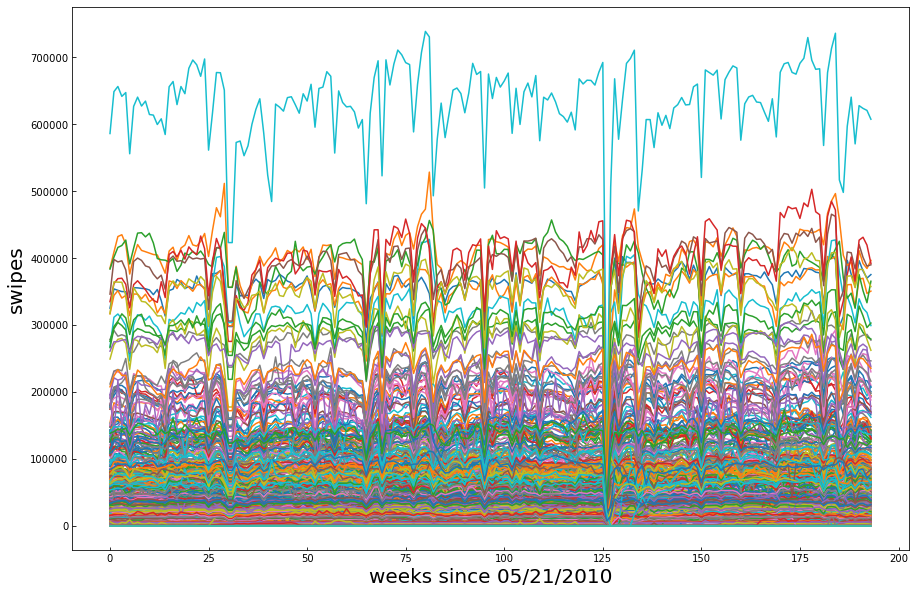

In [155]:
#plot data
pl.figure(figsize=(15,10))
for i in range(mta.shape[0]):
    allrides = [sum(mta[i,:,j]) for j in range(mta.shape[2])]
    pl.plot(allrides)
pl.xlabel("weeks since 05/21/2010", fontsize=20)
tmp = pl.ylabel("swipes", fontsize=20)  

Figure 1: time series for all stations summed over ride type

In [7]:
rng = pd.date_range('05/21/2010', periods=N, freq='W')
print ("nominal date range given the metadata\n", rng)

nominal date range given the metadata
 DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')


Figure 2: time series for all ride types all stations in semi-log space

In [8]:
mta_allsum = np.nansum(mta, axis=0)
print ("mta array collapsing station axis:", mta_allsum.shape)
mta_allsum = np.nansum(mta_allsum, axis=0)
print ("mta array collapsing ride type and station axes:", mta_allsum.shape)

mta array collapsing station axis: (23, 194)
mta array collapsing ride type and station axes: (194,)


3 sigma threshold 20825898.6
outlier index (array([126]),)
outlier date DatetimeIndex(['2012-10-21'], dtype='datetime64[ns]', freq=None)


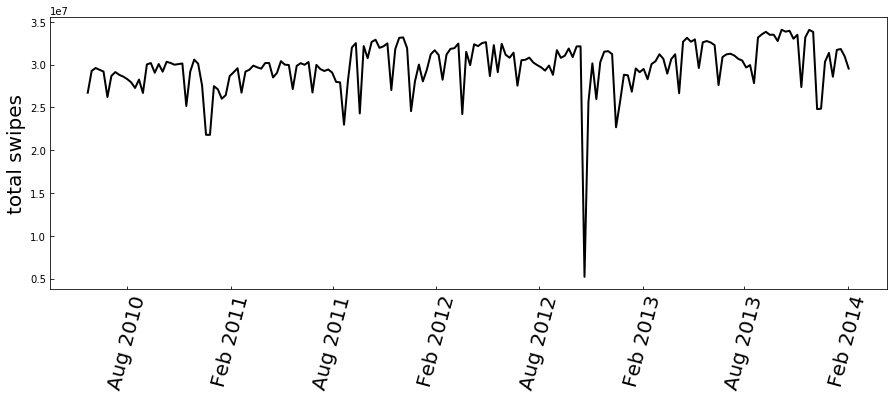

In [9]:
#plot all swipes
pl.figure(figsize=(15,5))
pl.plot(rng, mta_allsum, 'k-', lw = 2)
pl.xticks(rotation = 75, fontsize=20)
pl.ylabel("total swipes", fontsize=20)  
tsthresh = np.nanmean(mta_allsum) - 3 * np.std(mta_allsum)
print ("3 sigma threshold %.1f"%tsthresh)
print ("outlier index", np.where(mta_allsum < tsthresh))
print ("outlier date", rng[np.where(mta_allsum < tsthresh)])

# The outlier is near the date of sandy, but I am off by a week. I will reset the range accordingly

outlier date 2012-10-28


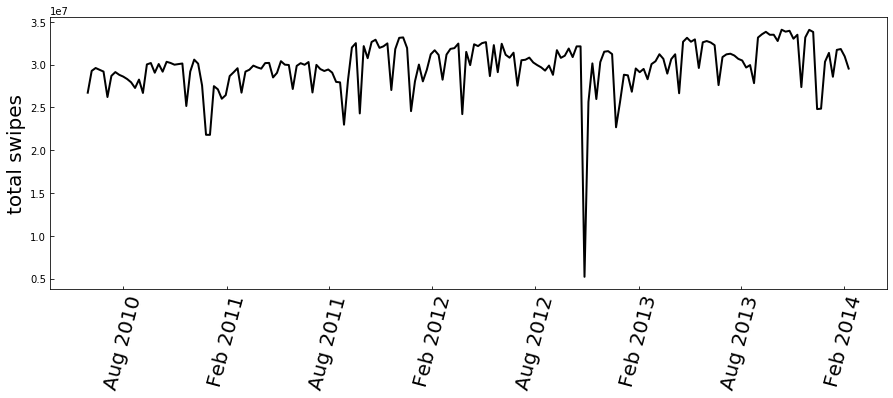

In [10]:
rng = pd.date_range('05/29/2010', periods=N, freq='W')
#plot all swipes
pl.figure(figsize=(15,5))
pl.plot(rng, mta_allsum, 'k-', lw = 2)
pl.xticks(rotation = 75, fontsize=20)
pl.ylabel("total swipes", fontsize=20)  
print ("outlier date", rng[np.where(mta_allsum < tsthresh)][0].date())

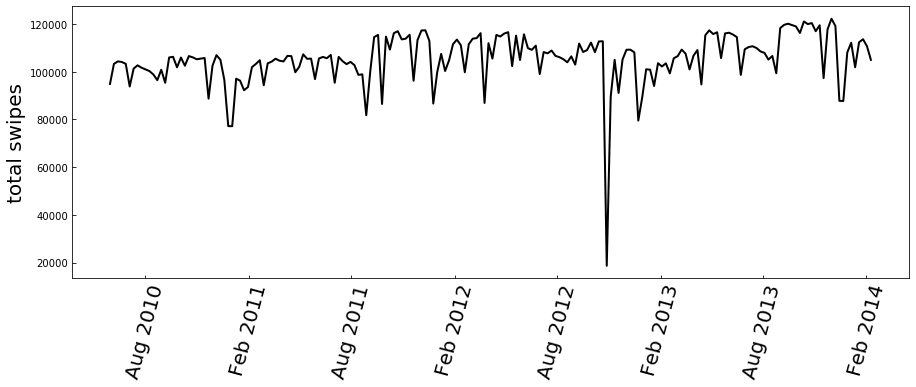

In [11]:
weightedrides = np.zeros((mta.shape[0], mta.shape[2]))

for i in range(mta.shape[0]):
    allrides = np.array([np.nansum(mta[i,:,j].flatten()) for j in range(mta.shape[2])])
    #print (allrides/nanmean(allrides)).shape, weightedrides.shape
    weightedrides[i] = allrides / np.sqrt(nanmean(allrides))
    #pl.plot(rng, np.log10(weightedrides[i]))
    #pl.xticks(rotation = 75)

    
#plot weighted by station, per ride
pl.figure(figsize=(15,5))
pl.plot(rng, np.nansum(weightedrides, axis=0), 'k-', lw = 2)
pl.xticks(rotation = 75, fontsize=20)
pl.ylabel("total swipes", fontsize=20)  
rides = pd.DataFrame({'t':rng, 'ridecounts':np.nansum(weightedrides, axis=0)})

Figure 3: time series for all rides weighted by mean number of rides per station in semi-log space

### find the ride type that has the steepest increase, and the steepest decrease. notice: we are looking ofr something that has a more or less constant trend

## to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per type. 

## you can use a rolling mean for smoothing, you can use the ratio of the flux near the beginning and the end if the time series, or fit a line to the time series and get its slope.  find series with the steepest upward trend, and the steepest downward trend.

## notice that you should inspect the time series, either algorithmically or by eye, to ensure you see a trend, and not just changing structure.


stdev 519705.73, fractional increase over time 1.07: 
stdev 62962.10, fractional increase over time 1.34: 
stdev 5484.34, fractional increase over time 1.18: 
stdev 8200.05, fractional increase over time 0.98: 
stdev 3471.64, fractional increase over time 1.08: 
stdev 614851.57, fractional increase over time 1.47: 
stdev 448552.87, fractional increase over time 0.93: 
stdev 3658.04, fractional increase over time 0.00: 
stdev 96197.57, fractional increase over time 0.00: 
stdev 198767.71, fractional increase over time 0.00: 
stdev 17745.48, fractional increase over time 0.89: 
stdev 24129.44, fractional increase over time 1.27: 
stdev 58579.27, fractional increase over time 28209.44: 
stdev 16498.07, fractional increase over time 0.60: 
stdev 145035.47, fractional increase over time 0.66: 
stdev 32495.16, fractional increase over time 2.67: 
stdev 17795.06, fractional increase over time 2.97: 
stdev 4524.89, fractional increase over time 67.96: 
stdev 29496.85, fractional increase over 

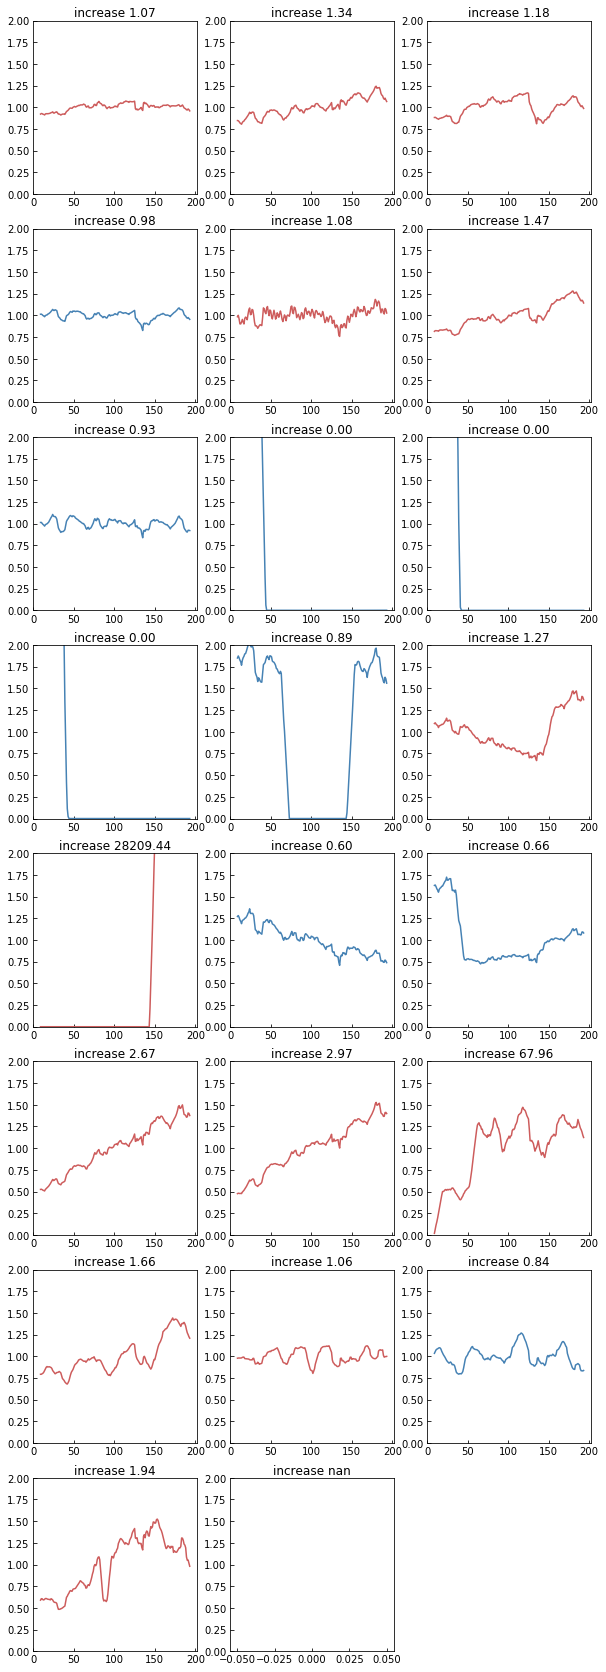

In [12]:
#remove series w bad data and store the rest in a new array
mtanew = np.empty_like(mta)
for i,m in enumerate(mta):
    for j,t in enumerate(m):
        if not -1 in t:
            mtanew[i][j] = t
mta = mtanew

increase = np.zeros((mta.shape[1],2))
fig = pl.figure(figsize=(10,30))
for i in range(mta.shape[1]):
    mta_allsum = mta[:,i,:]
    ax = fig.add_subplot(8,3,i+1)
    #rolling mean of rides by type
    thisride = pd.rolling_mean(np.nansum(mta_allsum, axis=0), 10)
    increase[i] = np.array([np.nanstd(thisride), 
                   np.nanmean(thisride[-10:]) / np.nanmean(thisride[:10])])
    print ("stdev {0:.2f}, fractional increase over time {1:.2f}: ".format(increase[i][0], 
                                                                            increase[i][1]))
    if increase[i][1] > 1:
        pl.plot(thisride / np.nanmean(thisride), color="IndianRed")
    else: 
        pl.plot(thisride / np.nanmean(thisride), color="SteelBlue")
    pl.ylim(0,2)
    pl.title("increase %.2f"%(increase[i][1]))
        


Figure 3: time series smoothed (rolling mean w window 10), normmalized,  in semi-log space. In red are possibly increasing trends

In [13]:
trendsort = np.argsort(increase[:,1])[::-1]
print ("order of increasing trend magnitude:", trendsort)
print ("corresponding stdev:", increase[trendsort,0])


order of increasing trend magnitude: [22 12 17 16 15 21 18  5  1 11  2  4  0 19  3  6 10 20 14 13  7  8  9]
corresponding stdev: [  0.00000000e+00   5.85792724e+04   4.52489475e+03   1.77950603e+04
   3.24951624e+04   2.52041044e+02   2.94968451e+04   6.14851567e+05
   6.29621004e+04   2.41294380e+04   5.48433683e+03   3.47164240e+03
   5.19705730e+05   1.57054506e+03   8.20005208e+03   4.48552874e+05
   1.77454822e+04   6.81417013e+02   1.45035465e+05   1.64980720e+04
   3.65803859e+03   9.61975736e+04   1.98767713e+05]


# the first smooth trend is for ride type at index 16 (by visual inspection)

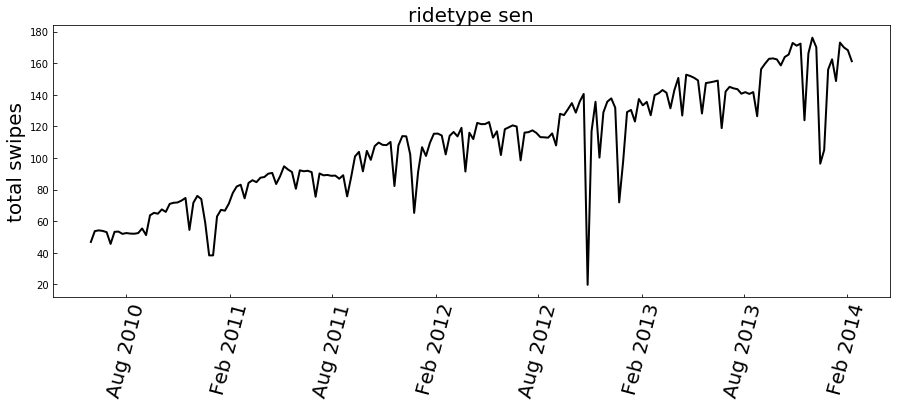

In [67]:
mtabyride = np.nanmean(mta, axis=0)
pl.figure(figsize=(15,5))
pl.plot(rng, mtabyride[16], 'k-', lw = 2)
pl.xticks(rotation = 75, fontsize=20)
pl.ylabel("total swipes", fontsize=20)  
title = pl.title ("ridetype " + ridetype[16], fontsize=20)

Figure 4: the steepest smooth increase in ridership type is for Senior passes. Above is the average over all station of the senior pass popularity

In [68]:
import statsmodels.api as sm
from statsmodels.stats.gof import chisquare
models = []
selectedIndeces = [17,16,15]
for i in selectedIndeces:
    models.append(sm.OLS(mtabyride[i], 
                         sm.add_constant(np.arange(mta.shape[2]))).fit())
    #(np.nanmean(mta, axis=0)[16])
for i,m in enumerate(models):
    print (selectedIndeces[i], "R^2 line fit %.2f"%m.rsquared)

17 R^2 line fit 0.47
16 R^2 line fit 0.82
15 R^2 line fit 0.80


# the fit to a straight line is best for index 16 as well, confirming that Senior rides have the steepest continuous increase among ride types 

Text(0.5,0,'period (weeks)')

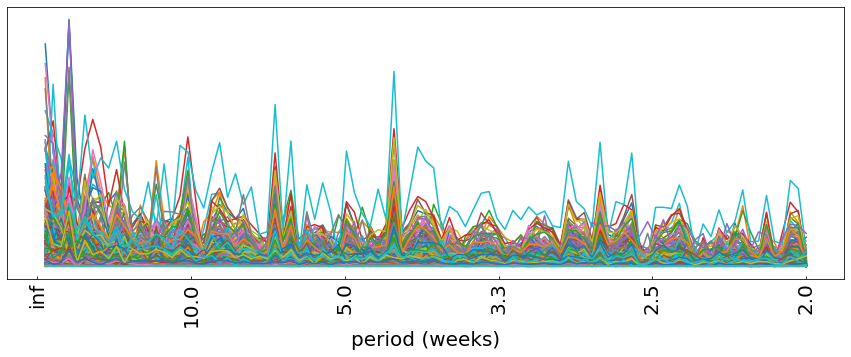

In [72]:
mtabystation = np.nanmean(mta, axis=1)
fig = pl.figure(figsize = (15,5))
ax = fig.add_subplot(111)
freqs = np.fft.rfftfreq(N, 1.0)
this_ffts =  np.array([np.abs(np.fft.rfft(mtabystation[i])) 
                       for i in range(mta.shape[0])])
for this_fft in this_ffts:
    ax.plot(freqs[1:], (this_fft[1:]))
allperiods = [1.0/N, 1./104, 1.0/52, 1.0/26, 1.0/13, 1.0/8, 1.0/4, 1.0/2]
ax.set_xticklabels([ "%.1f"%(1/f) for f in ax.get_xticks()], rotation=90, fontsize=20)
ax.set_yticks([])
pl.xlabel("period (weeks)", fontsize=20)


Figure 5: Power spectrum of  rides for all stations

Text(0.5,0,'period (weeks)')

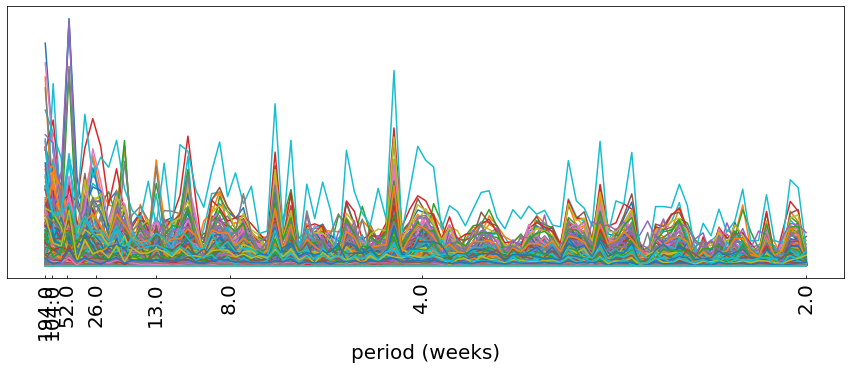

In [73]:
#plotting with a more informative set of x labels
fig = pl.figure(figsize = (15,5))
ax = fig.add_subplot(111)
this_ffts =  np.array([np.abs(np.fft.rfft(mtabystation[i]))
                       for i in range(mta.shape[0])])
for this_fft in this_ffts:
    ax.plot(freqs[1:],(this_fft[1:]))
allperiods = [1.0/194, 1./104, 1.0/52, 1.0/26, 1.0/13, 1.0/8, 1.0/4, 1.0/2]
ax.set_xticks (allperiods)
ax.set_xticklabels([ "%s"%(1/f) for f in allperiods], rotation=90, fontsize=20)
ax.set_yticks([])
pl.xlabel("period (weeks)", fontsize=20)


Figure 6: As figure 5, with more informative labeling of the x axis

In [84]:
yearindex = np.where(np.abs(freqs - 1.0/52) == min(np.abs(freqs - 1.0/52)))[0]
print ("index of frequency closest to %.1f weeks (%.1f)"%(1.0/freqs[yearindex], yearindex))


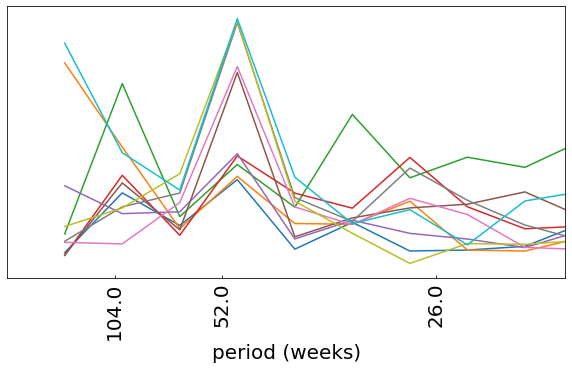

In [97]:
fig = pl.figure(figsize = (10,5))
ax = fig.add_subplot(111)

#52 weeks (or close to that) is the 4th cell of the fourier transform array. 
#I am sorting by the power in that cell and taking the indeces of the sorted array 
#(that is what argsort returns)
yearly_sorted =  np.array(this_ffts).T[4].argsort()
yearly_sorted = yearly_sorted[~np.isnan(np.array(this_ffts)[yearly_sorted[:],4])]

#print np.array(this_ffts)[yearly_sorted[-20:]]
for this_fft in np.array(this_ffts)[yearly_sorted[-10:]]:
    
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:],(this_fft[1:]))
allperiods = [1./104, 1.0/52, 1.0/26]
ax.set_xlim(0,0.05)
ax.set_xticks (allperiods)
ax.set_yticks ([])
tmp = ax.set_xticklabels([ "%s"%(1/f) for f in allperiods], rotation=90, fontsize=20)
tmp = pl.xlabel("period (weeks)", fontsize=20)


Figure 7: Zoom-in of the power spectra of riderships for all stations around the 1-year periodicity region

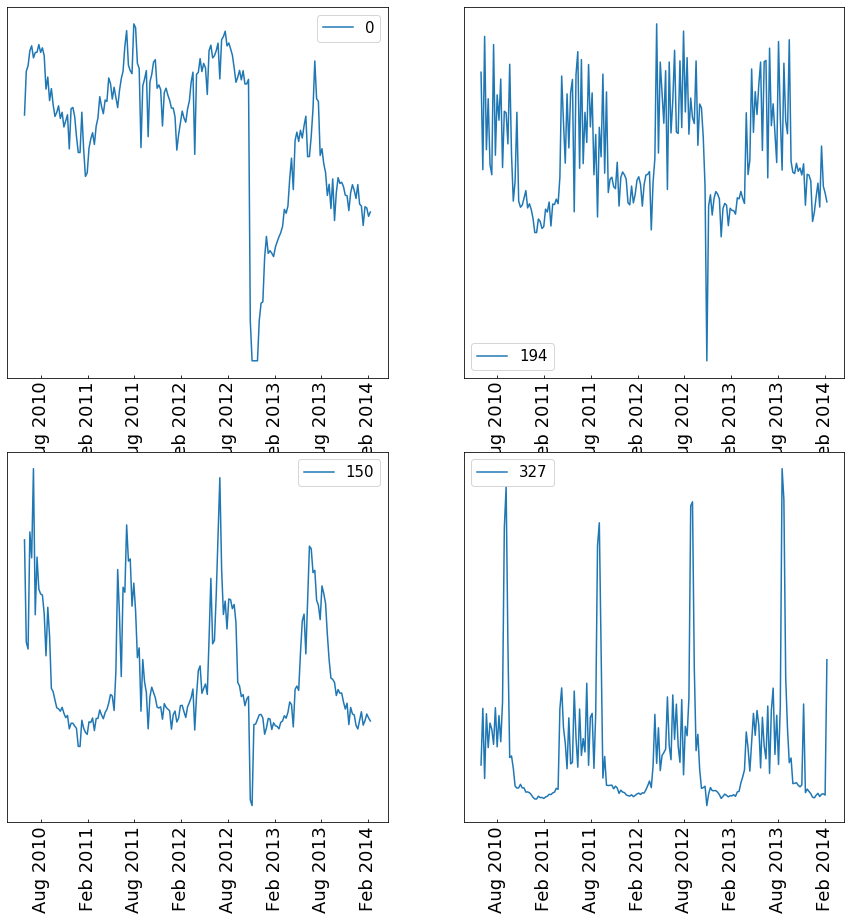

In [122]:
#plotting top 4 annually-periodic time series
fig = pl.figure(figsize=(15,15))
for i,j in enumerate(yearly_sorted[-1:-5:-1]):
    
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(rng, weightedrides[j], label="%d"%j)
    pl.legend(fontsize = 15)
    ax.set_yticks([])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
        tick.label.set_rotation('vertical')


Figure 8: The 4 station that shows the most clear periodicity at 1-year

In [156]:
from sklearn.cluster import KMeans
#clustering in 9 clusters

nc = 9
data = np.load("MTA_Fare.npy")

tots = data.transpose(2,0,1).reshape(data.shape[2], 
                                     data.shape[1]*data.shape[0]).T
# remove null time series
tots = tots[tots.std(1)>0]

km = KMeans(n_clusters=nc)

#standardizing before clustering
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

km.fit(vals)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=9, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

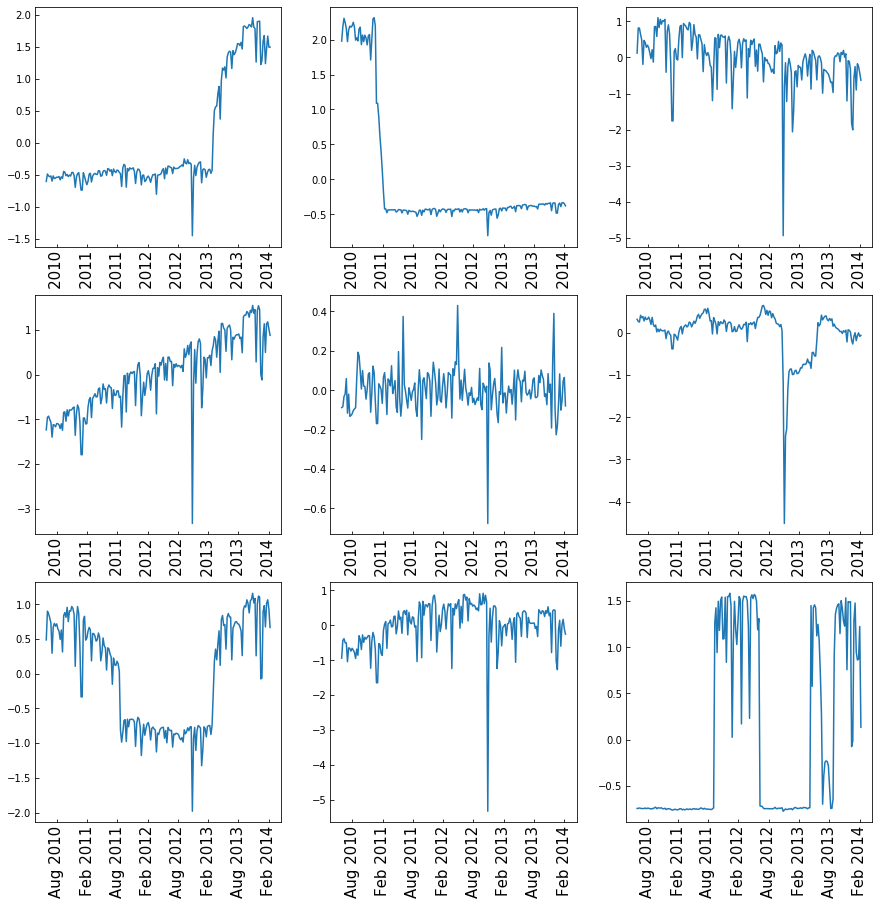

In [127]:
fig = pl.figure(figsize=(15,15))
for i,cc in enumerate(km.cluster_centers_):
    ax = fig.add_subplot(3,3,i+1)
    ax.plot(rng, cc)
    ax.set_yticks([])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15) 
        tick.label.set_rotation('vertical')

Figure 3: K-means cluster centers (9 clusters) with random start points for all rides by type and station

In [130]:
for lab in set(km.labels_):
    print ('there are ', sum(km.labels_==lab), "time series in cluster", lab)


there are  1173 time series in cluster 0
there are  1748 time series in cluster 1
there are  897 time series in cluster 2
there are  1783 time series in cluster 3
there are  932 time series in cluster 4
there are  511 time series in cluster 5
there are  839 time series in cluster 6
there are  976 time series in cluster 7
there are  458 time series in cluster 8


In [151]:
distance = (np.array([vals - km.cluster_centers_[i]
                      for i in range (len(km.cluster_centers_))])**2)
for lab in set(km.labels_):
    print ("for cluster ", lab, "the average distance to the center is %.2f"\
           %np.mean(distance[lab][km.labels_==lab]))


for cluster  0 the average distance to the center is 0.99
for cluster  1 the average distance to the center is 0.15
for cluster  2 the average distance to the center is 0.34
for cluster  3 the average distance to the center is 0.51
for cluster  4 the average distance to the center is 0.28
for cluster  5 the average distance to the center is 0.41
for cluster  6 the average distance to the center is 0.56
for cluster  7 the average distance to the center is 0.68
for cluster  8 the average distance to the center is 0.05
